In [1]:
import arviz as az
import bambi as bmb
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
%load_ext watermark
az.style.use("arviz-darkgrid")
np.random.seed(1211)

#### Code 6.1

In [3]:
np.random.seed(3)
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold
selected = s >= q
cor = np.corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

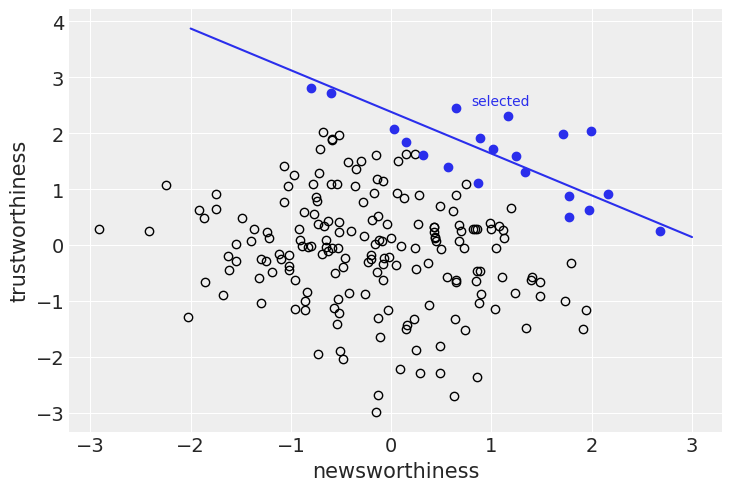

In [4]:
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

# correlation line
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))

plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness");

#### Code 6.2

In [5]:
N = 100                                                       # number of individuals
height = np.random.normal(10, 2, N)                           # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)                     # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)   # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

# combine into data frame
d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  
d.head()

,height,leg_left,leg_right
0,10.178107,4.206429,4.158048
1,11.557794,4.769875,4.825845
2,12.529290,5.543952,5.529080
3,8.238977,3.853735,3.801846
4,10.472811,4.333044,4.290579


#### Code 6.3

In [6]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=10, sd=100),
    "leg_left": bmb.Prior("Normal", mu=2, sd=10),
    "leg_right": bmb.Prior("Normal", mu=2, sd=10),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_1 = bmb.Model("height ~ leg_left + leg_right", d, priors=priors)
results_6_1 = model_6_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, leg_right, leg_left, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 82 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
az.summary(results_6_1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,0.985,0.329,0.368,1.598
leg_left,-1.851,2.310,-6.599,2.121
leg_right,3.876,2.303,-0.236,8.466
height_sigma,0.646,0.044,0.574,0.739


Note the heigh variability in the estimates and the lack of consistency with the results in the book in terms of point estimates... This is because of the multicollinearity!!

#### Code 6.4

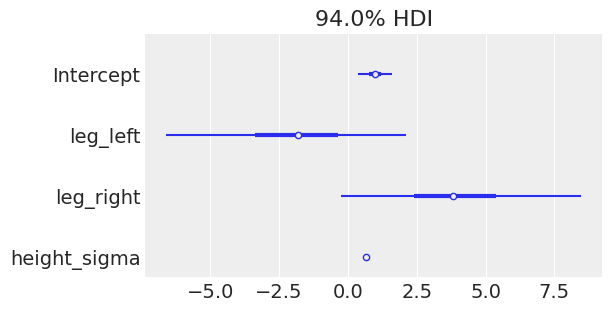

In [8]:
az.plot_forest(results_6_1, combined=True, figsize=[6, 3]);

#### Code 6.5 and 6.6

In [9]:
# Grab samples from the posteriors
leg_left = results_6_1.posterior["leg_left"].values.flatten()
leg_right = results_6_1.posterior["leg_right"].values.flatten()

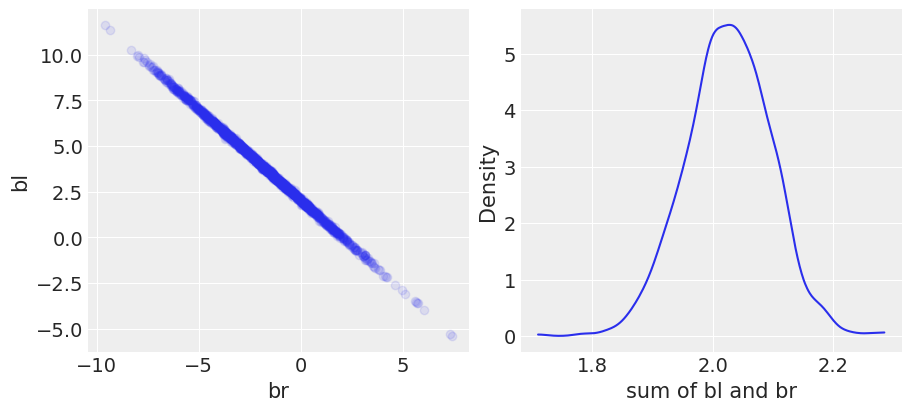

In [10]:
fig, ax = plt.subplots(1, 2, figsize=[9, 4])

# code 6.5
ax[0].scatter(leg_left, leg_right, alpha=0.1)
ax[0].set_xlabel("br")
ax[0].set_ylabel("bl")

# code 6.6
az.plot_kde(leg_left + leg_right, ax=ax[1])
ax[1].set_ylabel("Density")
ax[1].set_xlabel("sum of bl and br");

#### Code 6.7

We can use the same `priors` dict that we used above. Bambi will just omit the prior for `leg_right`.

In [11]:
model_6_2 = bmb.Model("height ~ leg_left", d, priors=priors)
results_6_2 = model_6_2.fit()
az.summary(results_6_2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, leg_left, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7061828650088336, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%
Intercept,0.905,0.344,0.220,1.513
leg_left,2.037,0.074,1.900,2.183
height_sigma,0.651,0.047,0.565,0.738


#### Code 6.8

We have to define `standardize()`

In [12]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

In [13]:
d = pd.read_csv("data/milk.csv")
d["K"] = standardize(d["kcal.per.g"])
d["F"] = standardize(d["perc.fat"])
d["L"] = standardize(d["perc.lactose"])

#### Code 6.9

In [14]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2),
    "F": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_3 = bmb.Model("K ~ F", d, priors=priors)
results_6_3 = model_6_3.fit()

priors["L"] = bmb.Prior("Normal", mu=0, sd=0.5)
model_6_4 = bmb.Model("K ~ L", d, priors=priors)
results_6_4 = model_6_4.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, F, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, L, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [15]:
az.summary(results_6_3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-0.000,0.086,-0.155,0.170
F,0.858,0.094,0.682,1.033
K_sigma,0.495,0.070,0.372,0.627


In [16]:
az.summary(results_6_4, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-0.002,0.074,-0.142,0.136
L,-0.898,0.078,-1.045,-0.752
K_sigma,0.420,0.061,0.316,0.540


#### Code 6.10

In [17]:
model_6_5 = bmb.Model("K ~ F + L", d, priors=priors)
results_6_5 = model_6_5.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, L, F, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


#### Code 6.11

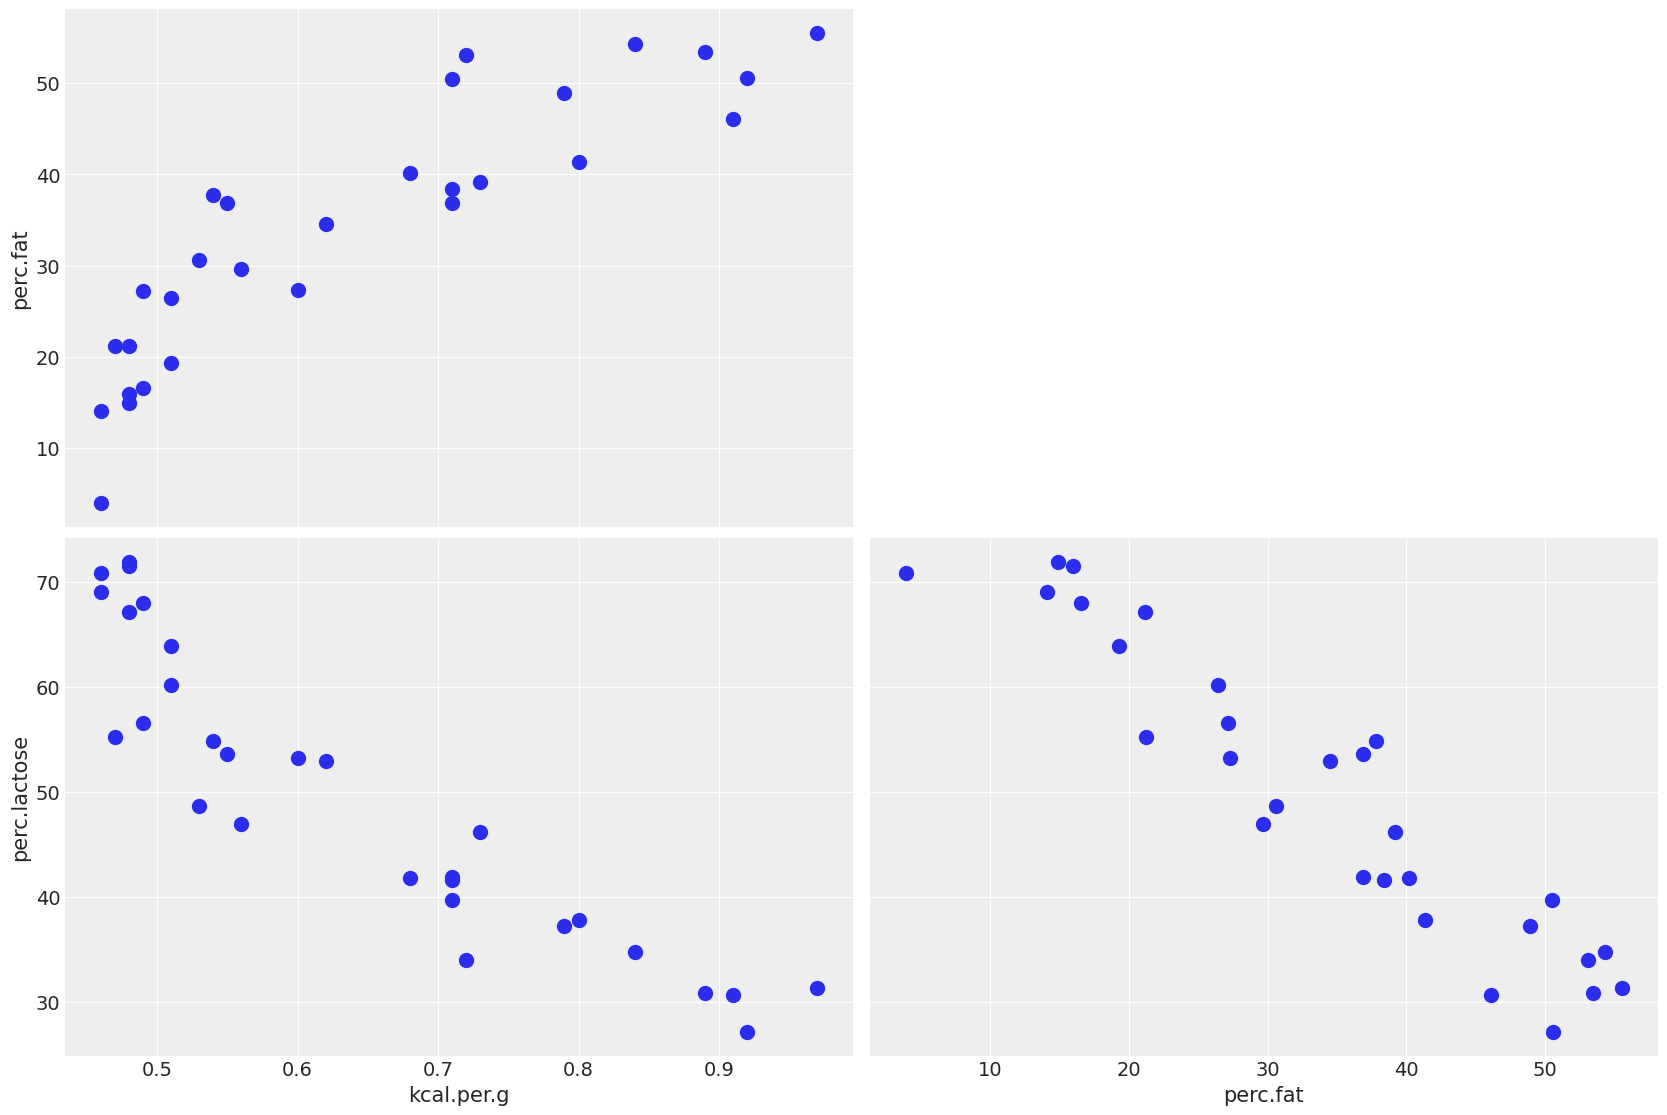

In [18]:
az.plot_pair(
    d[["kcal.per.g", "perc.fat", "perc.lactose"]].to_dict("list"),
    scatter_kwargs={"markersize": 20},
);

#### Code 6.12

In [19]:
d = pd.read_csv("data/milk.csv")

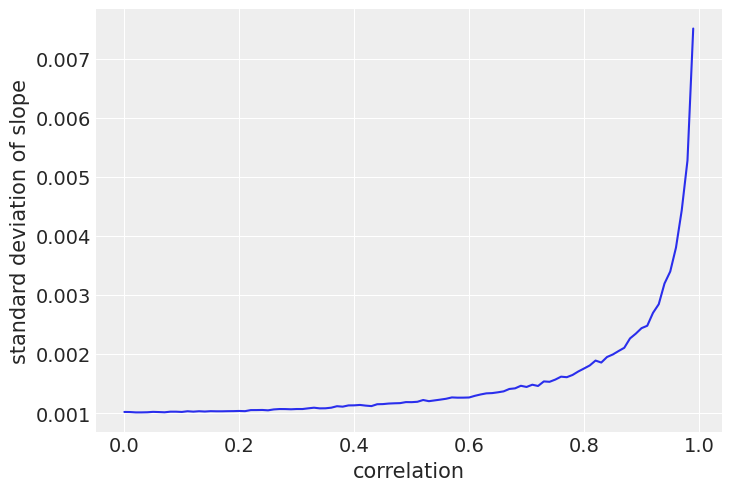

In [20]:
def sim_coll(r=0.9):
    x = np.random.normal(
        loc=r * d["perc.fat"], 
        scale=np.sqrt((1 - r ** 2) * np.var(d["perc.fat"]))
    )
    endog = sm.add_constant(np.vstack([d["perc.fat"], x]).T)
    model_fit = sm.OLS(d["kcal.per.g"], endog).fit()
    return np.sqrt(np.diag(model_fit.cov_params())[1]) # stddev of parameter

def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(n)])

r_seq = np.arange(0, 1, 0.01)
stddev = stdev = list(map(rep_sim_coll, r_seq))

plt.plot(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

#### Code 6.13

In [21]:
# number of plants
N = 100

# simulate initial heights
h0 = np.random.normal(10, 2, N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)

# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
h0,10.033,1.865,6.754,13.333
h1,14.251,2.428,9.336,17.838
treatment,0.500,0.503,0.000,1.000
fungus,0.260,0.441,0.000,1.000


#### Code 6.14

In [22]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))
az.summary(sim_p, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,1.034,0.265,0.573,1.521


#### Code 6.15

In [23]:
priors = {
    "h0": bmb.Prior("Lognormal", mu=0, sigma=0.25),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_6 = bmb.Model("h1 ~ 0 + h0", d, priors=priors)
results_6_6 = model_6_6.fit()
az.summary(results_6_6, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h1_sigma, h0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%
h0,1.403,0.018,1.368,1.436
h1_sigma,1.876,0.134,1.633,2.131


#### Code 6.16

This is an example where the code in the book cannot be directly translated to our formula notation. But don't worry! We still can figure out how to do it Bambi! We just need to have a closer look at the definition and re-arrange some stuff.

In the book we have 

$$
\begin{array}{c}
    \mu_i = h_{0, i} \times p \\
    p = \alpha + \beta_TT_i + \beta_FF_i
\end{array}
$$

With priors for $\alpha, \beta_T$, and $\beta_F$

If we distribute $h_{0, i}$ in the multiplication we have 

$$
h_{0, i} \times p = h_{0, i} \times (\alpha + \beta_TT_i + \beta_FF_i) = \alpha h_{0, i} + \beta_Th_{0, i}T_i + \beta_Fh_{0, i}F_i
$$

Where we can see that alpha is the coefficient for the effect of $h_0$, $\beta_T$ is the coefficient for the interaction between $h_0$ and $T$, and $\beta_F$ is the coefficient for the interaction between $h_0$ and $F$.

Therefore, we can think the model is of the form `response ~ main effect + interaction1 + interaction2`, which applied to our problem is `h1 ~ 0 + h0 + h0:treatment + h0:fungus`, where the `0` removes the intercept that is added by default.

A shorthand for this same model is `h1 ~ 0 + h0 + h0:(treament + fungus)` because the full interaction operator `:` is distributed over the terms on the right.

In [24]:
priors = {
    "h0": bmb.Prior("Lognormal", mu=0, sigma=0.2),
    "h0:treatment": bmb.Prior("Normal", mu=0, sd=0.5),
    "h0:fungus": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_7 = bmb.Model("h1 ~ 0 + h0 + h0:treatment + h0:fungus", d, priors=priors)
results_6_7 = model_6_7.fit()
az.summary(results_6_7, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h1_sigma, h0:fungus, h0:treatment, h0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%
h0:treatment,0.004,0.026,-0.043,0.052
h0:fungus,-0.304,0.028,-0.357,-0.251
h0,1.486,0.020,1.447,1.523
h1_sigma,1.252,0.091,1.096,1.422


#### Code 6.17

In [25]:
priors = {
    "h0": bmb.Prior("Lognormal", mu=0, sigma=0.2),
    "h0:treatment": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_8 = bmb.Model("h1 ~ 0 + h0 + h0:treatment", d, priors=priors)
results_6_8 = model_6_8.fit()
az.summary(results_6_8, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h1_sigma, h0:treatment, h0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%
h0:treatment,0.087,0.037,0.018,0.156
h0,1.363,0.026,1.316,1.412
h1_sigma,1.834,0.132,1.576,2.076


#### Code 6.18

Using [causalgraphicalmodels](https://github.com/ijmbarr/causalgraphicalmodels) for graph drawing and analysis instead of dagitty, following the example of [ksachdeva's Tensorflow version of Rethinking](https://ksachdeva.github.io/rethinking-tensorflow-probability/).

/home/tomas/anaconda3/envs/bmbrsrc/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


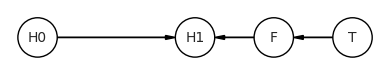

In [26]:
import daft

from causalgraphicalmodels import CausalGraphicalModel

plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

#### Code 6.19

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [27]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('F', 'H0', set())
('T', 'H1', {'F'})
('T', 'H0', set())


#### 6.20

In [28]:
N = 1000
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(1, 0.5, size=N)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4 + 0.4 * M, size=N)
h1 = h0 + np.random.normal(5 + 3 * M, size=N)
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
h0,10.088,1.924,6.583,13.709
h1,16.628,2.678,11.795,21.660
treatment,0.500,0.500,0.000,1.000
fungus,0.487,0.500,0.000,1.000


#### Code 6.21

We need to define the `inv_logit()` and `sim_happiness()` functions that come with the `rethinking` package in R.

In [29]:
def inv_logit(x):
    p = 1 / (1 + np.exp(-x))
    p = np.where(p == 1, 1 - np.finfo(float).eps, p)
    p = np.where(p == 0, np.finfo(float).eps, p)
    return p


def sim_happiness(seed=1234, N_years=1000, max_age=65, N_births=20, aom=18):
    np.random.seed(seed)
    
    A = np.array([])
    H = np.array([])
    M = np.array([])
    
    for t in range(N_years):
        A = A + 1
        A = np.concatenate([A, np.array([1] * N_births)])
        H = np.concatenate([H, np.linspace(-2, 2, N_births)])
        M = np.concatenate([M, np.array([0] * N_births)])
        
        for i in range(len(A)):
            if A[i] >= aom and M[i] == 0:
                M[i] = np.random.binomial(1, inv_logit(H[i] - 4))
            
        deaths = np.where(A > max_age)
        
        if len(deaths):
            A = np.delete(A, deaths)
            H = np.delete(H, deaths)
            M = np.delete(M, deaths)
    
    return pd.DataFrame({"age": A, "married": M, "happiness": H})

In [30]:
d = sim_happiness(seed=1977, N_years=1000)

In [31]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
age,33.000,18.769,1.0,62.000
married,0.292,0.455,0.0,1.000
happiness,-0.000,1.214,-2.0,1.789


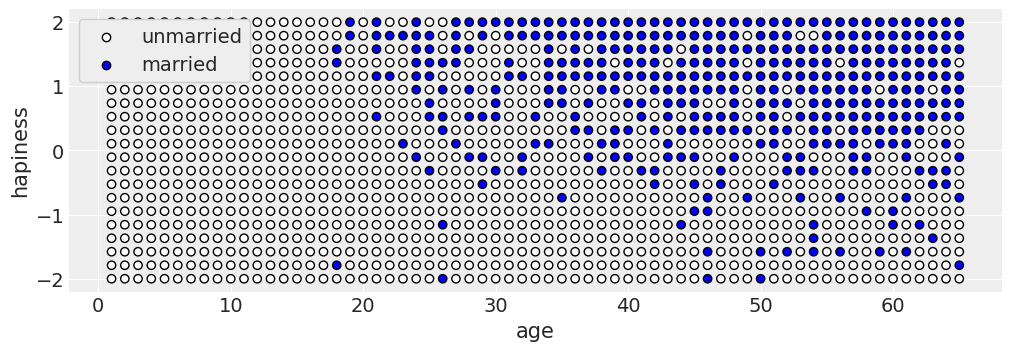

In [32]:
# Figure 6.4
fig, ax = plt.subplots(figsize=[10, 3.4])

colors = np.where(d["married"] == 1, "b", "w")
ax.scatter(d["age"], d["happiness"], edgecolor="k", color=colors)

ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)

ax.set_xlabel("age")
ax.set_ylabel("hapiness");

#### Code 6.22

In [33]:
d2 = d[d["age"] > 17].copy() # only adults
d2["A"] = (d2["age"] - 18) / (65 - 18)

#### Code 6.23

In [34]:
d2.head()

,age,married,happiness,A
0,65.0,0.0,-2.000000,1.0
1,65.0,1.0,-1.789474,1.0
2,65.0,0.0,-1.578947,1.0
3,65.0,0.0,-1.368421,1.0
4,65.0,0.0,-1.157895,1.0


In [35]:
d2["mid"] = d2["married"] + 1

priors = {
    "C(mid)": bmb.Prior("Normal", mu=0, sd=1),
    "A": bmb.Prior("Normal", mu=0, sd=2),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_9 = bmb.Model("happiness ~ 0 + C(mid) + A", d2, priors=priors)
results_6_9 = model_6_9.fit()
az.summary(results_6_9, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [happiness_sigma, A, C(mid)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%
C(mid)[0],-0.247,0.066,-0.364,-0.120
C(mid)[1],1.273,0.087,1.106,1.433
A,-0.708,0.118,-0.930,-0.499
happiness_sigma,0.983,0.021,0.944,1.024


The 0 and 1 in the label of `C(mid)` are not the values of `mid`, but the indices of the dimensions those values represent. Hopefully, we'll fix it in Bambi soon.

#### Code 6.24

In [36]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=1),
    "A": bmb.Prior("Normal", mu=0, sd=2),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_10 = bmb.Model("happiness ~ A", d2, priors=priors)
results_6_10 = model_6_10.fit()
az.summary(results_6_10, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [happiness_sigma, A, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8790845897415182, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%
Intercept,-0.003,0.082,-0.148,0.156
A,0.005,0.143,-0.273,0.260
happiness_sigma,1.216,0.029,1.166,1.275


#### Code 6.25

In [37]:
N = 200  # number of of grandparent-parent-child triads
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

#### Code 6.26

In [38]:
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP * G + b_U * U)
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

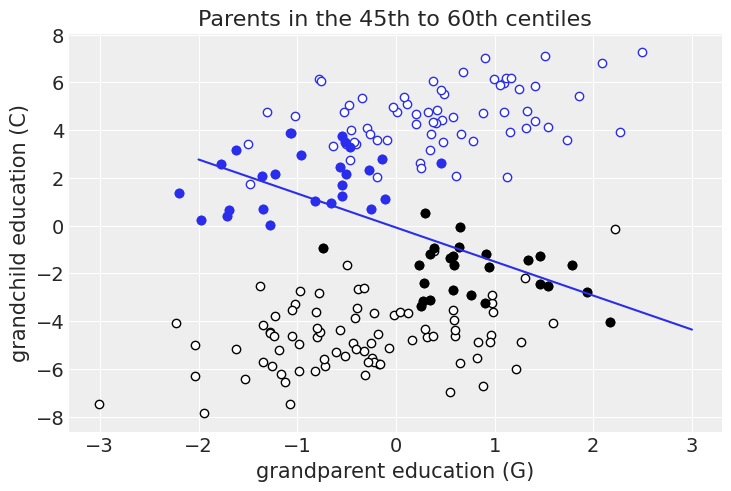

In [39]:
# Figure 6.5

# grandparent education
bad = U < 0
good = ~bad
plt.scatter(G[good], C[good], color="w", lw=1, edgecolor="C0")
plt.scatter(G[bad], C[bad], color="w", lw=1, edgecolor="k")

# parents with similar education
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color="C0", lw=1, edgecolor="C0")
plt.scatter(G[bad & eP], C[bad & eP], color="k", lw=1, edgecolor="k")


p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2, 3])
plt.plot(xn, np.polyval(p, xn))

plt.xlabel("grandparent education (G)")
plt.ylabel("grandchild education (C)")
plt.title("Parents in the 45th to 60th centiles");

#### Code 6.27

In [40]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=1),
    "P": bmb.Prior("Normal", mu=0, sd=1),
    "G": bmb.Prior("Normal", mu=0, sd=1),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_11 = bmb.Model("C ~ P + G", d, priors=priors)
results_6_11 = model_6_11.fit()
az.summary(results_6_11, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [C_sigma, G, P, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,-0.055,0.091,-0.223,0.110
P,1.841,0.044,1.757,1.920
G,-1.002,0.104,-1.185,-0.804
C_sigma,1.292,0.066,1.175,1.419


#### Code 6.28

In [41]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=1),
    "P": bmb.Prior("Normal", mu=0, sd=1),
    "G": bmb.Prior("Normal", mu=0, sd=1),
    "U": bmb.Prior("Normal", mu=0, sd=1),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_6_12 = bmb.Model("C ~ P + G + U", d, priors=priors)
results_6_12 = model_6_12.fit()
az.summary(results_6_12, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [C_sigma, U, G, P, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,-0.048,0.072,-0.176,0.090
P,1.124,0.075,0.989,1.265
G,-0.264,0.106,-0.447,-0.053
U,1.734,0.157,1.445,2.023
C_sigma,0.994,0.051,0.898,1.087


#### Code 6.29
Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [42]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'A'})
frozenset({'C'})


#### Code 6.30
Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [43]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[
        ("S", "A"),
        ("A", "D"),
        ("S", "M"),
        ("M", "D"),
        ("S", "W"),
        ("W", "D"),
        ("A", "M"),
    ],
)
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'S'})
frozenset({'A', 'M'})


#### Code 6.31
Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [44]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('S', 'D', {'W', 'A', 'M'})
('W', 'A', {'S'})
('W', 'M', {'S'})


In [45]:
%watermark -n -u -v -iv -w

Last updated: Fri Apr 30 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

numpy      : 1.20.2
pandas     : 1.2.4
json       : 2.0.9
scipy      : 1.6.2
daft       : 0.1.2
bambi      : 0.4.1
arviz      : 0.11.2
statsmodels: 0.12.2
matplotlib : 3.4.1

Watermark: 2.2.0

